**SEMI SUPERVISED** without actigraphy

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
train_df=pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout

# Mapping for converting season names to numerical values
season_mapping = {
    'Fall': 0,
    'Winter': 1,
    'Spring': 2,
    'Summer': 3,
}

# Initialize an empty list to store column names that contain 'Season'
season_columns = []

# Iterate over the columns of the training DataFrame to find columns related to seasons
for col in train_df.keys():
    if 'Season' in col:  # Check if 'Season' is part of the column name
        season_columns.append(col)  # Add the column to the season_columns list

# Print the columns identified as season-related for verification
print(season_columns)

# Replace the season names in the identified columns with their corresponding numerical values
train_df[season_columns] = train_df[season_columns].replace(season_mapping)

# Display the updated DataFrame
train_df

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the DataFrame into features (X) and target (y)
X = train_df.drop(columns=['sii'])  # Drop the 'sii' column to use the rest as features
y = train_df['sii']  # The target variable is 'sii'

# Split the data into training+testing and inference sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42  # Use 10% of the data for testing; set a random state for reproducibility
)

# Optional second split for validation (commented out here):
# Split the training+testing set further into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_val, y_train_val, test_size=0.2, random_state=42
# )  
# This would create a validation set that is 20% of the training set, equivalent to 0.2 * 0.9 = 18% of the total data

# Print the unique values in the training target variable for verification
print(np.unique(y_train))

# Display the feature set (optional, for checking)
X

In [ ]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

def create_dual_input_model(base_input_dim, extra_features_dim, encoding_dim=32, dropout_rate=0.3):
    """
    Creates a model with two training modes:
    1. Unsupervised learning with only base features (autoencoder).
    2. Supervised learning with combined base and extra features.
    """
    # Input layer for base features
    base_input = Input(shape=(base_input_dim,), name='base_input')

    # Encoder layers for base features
    encoded = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(base_input)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)

    encoded = Dense(48, activation='relu', kernel_regularizer=l2(1e-4))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(dropout_rate)(encoded)

    # Bottleneck layer for encoding base features
    bottleneck = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)

    # Create encoder model (for feature extraction)
    encoder = Model(inputs=base_input, outputs=bottleneck, name='encoder')

    # Decoder layers for reconstructing input (autoencoder)
    decoded = Dense(48, activation='relu', kernel_regularizer=l2(1e-4))(bottleneck)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)

    decoded = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(dropout_rate)(decoded)

    # Output layer for autoencoder
    decoder_output = Dense(base_input_dim, activation='sigmoid')(decoded)

    # Create autoencoder model (base_input -> reconstruction)
    autoencoder = Model(inputs=base_input, outputs=decoder_output, name='autoencoder')

    # Input layer for extra features (only used in supervised training)
    extra_input = Input(shape=(extra_features_dim,), name='extra_input')

    # Concatenate bottleneck output with extra features for supervised training
    combined = Concatenate()([bottleneck, extra_input])

    # Fully connected layers for supervised learning
    supervised = Dense(96, activation='relu', kernel_regularizer=l2(1e-4))(combined)
    supervised = BatchNormalization()(supervised)
    supervised = Dropout(dropout_rate)(supervised)

    supervised = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(supervised)
    supervised = BatchNormalization()(supervised)
    supervised = Dropout(dropout_rate)(supervised)

    supervised = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(supervised)
    supervised = BatchNormalization()(supervised)
    supervised = Dropout(dropout_rate)(supervised)

    # Output layer for classification (adjust number of classes as needed)
    output = Dense(4, activation='softmax')(supervised)

    # Create supervised model (combined inputs -> classification output)
    supervised_model = Model(inputs=[bottleneck, extra_input], outputs=output, name='supervised')

    return autoencoder, encoder, supervised_model

def prepare_data_for_training(X_unlabeled, X_labeled, extra_features_cols, impute_strategy='median', normalize=True):
    """
    Prepares data for training by imputing missing values and normalizing.
    """
    # Identify base features (columns not in extra_features_cols)
    base_features = [col for col in X_unlabeled.columns if col not in extra_features_cols]
    print(base_features)

    # Impute missing values using the specified strategy
    imputer = SimpleImputer(strategy=impute_strategy)

    # Impute and transform base features for unlabeled data
    X_unlabeled_base = X_unlabeled[base_features].copy()
    X_unlabeled_base_imputed = imputer.fit_transform(X_unlabeled_base)

    # Impute and transform base features for labeled data
    X_labeled_base = X_labeled[base_features].copy()
    X_labeled_base_imputed = imputer.fit_transform(X_labeled_base)

    # Impute and transform extra features for labeled data
    X_labeled_extra = X_labeled[extra_features_cols].copy()
    X_labeled_extra_imputed = imputer.fit_transform(X_labeled_extra)

    # Normalize data if specified
    if normalize:
        scaler = MinMaxScaler()  # StandardScaler() can be used as an alternative
        X_unlabeled_base_imputed = scaler.fit_transform(X_unlabeled_base_imputed)
        X_labeled_base_imputed = scaler.fit_transform(X_labeled_base_imputed)
        X_labeled_extra_imputed = scaler.fit_transform(X_labeled_extra_imputed)

    # Return processed data as DataFrames for consistency
    return (
        pd.DataFrame(X_unlabeled_base_imputed, columns=base_features),
        pd.DataFrame(X_labeled_base_imputed, columns=base_features),
        pd.DataFrame(X_labeled_extra_imputed, columns=extra_features_cols)
    )

def train_models(X_unlabeled, X_labeled, y_labeled, extra_features_cols, encoding_dim=32):
    """
    Trains both unsupervised (autoencoder) and supervised models.
    """
    # Prepare data for training
    X_unlabeled_base, X_labeled_base, X_labeled_extra = prepare_data_for_training(
        X_unlabeled, X_labeled, extra_features_cols
    )

    print('X labeled base', X_unlabeled_base.shape, 'labeled data', X_labeled_base.shape, 'labeled data extra features', X_labeled_extra.shape)

    # Create models
    autoencoder, encoder, supervised_model = create_dual_input_model(
        base_input_dim=len(X_unlabeled_base.columns),  # Input dimension for base features
        extra_features_dim=len(extra_features_cols),   # Input dimension for extra features
        encoding_dim=encoding_dim                      # Size of encoding layer
    )

    # Compile the models with appropriate loss and optimization functions
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    supervised_model.compile(optimizer='adam', 
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

    # Train the autoencoder
    autoencoder_history = autoencoder.fit(
        X_unlabeled_base, X_unlabeled_base,  # Input and target are the same for reconstruction
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.2, patience=5)
        ]
    )

    # Use the encoder to extract features from labeled data
    encoded_features = encoder.predict(X_labeled_base)

    # Check shapes to ensure compatibility for training the supervised model
    print(f'Encoded features shape: {encoded_features.shape}')
    print(f'Extra features shape: {X_labeled_extra.shape}')
    assert encoded_features.shape[1] == encoding_dim, "Mismatch in encoded features shape"
    assert X_labeled_extra.shape[1] == len(extra_features_cols), "Mismatch in extra features shape"

    # Train the supervised model
    supervised_history = supervised_model.fit(
        [encoded_features, X_labeled_extra],  # Combined inputs
        y_labeled,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.2, patience=5)
        ]
    )

    return autoencoder, encoder, supervised_model, autoencoder_history, supervised_history

# Main code for preparing data and training models
columns = ['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 
           'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 
           'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 
           'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 
           'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 
           'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total']

columns_to_drop = columns.copy()

# Splitting data into unlabeled and labeled sets
X_unlabeled = X_train[y_train.isna()].drop(columns=columns_to_drop)
X_unlabeled = X_unlabeled.drop(columns='id')
X_labeled = X_train[y_train.notna()].drop(columns='id')
y_labeled = y_train[y_train.notna()].values

print('Target distribution:', pd.Series(y_labeled).value_counts())

# Get extra features used for training
extra_features_cols = [col for col in X_labeled.columns if col not in columns_to_drop]
X_labeled.drop(columns=columns_to_drop, inplace=True)

# Convert target labels to categorical
y_labeled = to_categorical(y_labeled, num_classes=4)

# Train models
autoencoder, encoder, supervised_model, autoencoder_history, supervised_history = train_models(
    X_unlabeled, X_labeled, y_labeled, extra_features_cols
)

In [ ]:
# Importing essential libraries for data manipulation, analysis, and visualization
import numpy as np  # Library for numerical operations, useful for handling arrays and numerical data
import pandas as pd  # Library for data manipulation and analysis, ideal for working with DataFrame structures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Tools for evaluating model performance through confusion matrix
import matplotlib.pyplot as plt  # Library for creating static, interactive, and animated visualizations

def perform_inference(autoencoder, encoder, supervised_model, X_unseen, extra_features_cols, impute_strategy='median'):
    """
    Perform inference using trained models (autoencoder, encoder, and supervised) on unseen data.
    Preprocesses the data by imputing missing values and normalizing it, then makes predictions.

    Parameters:
    - autoencoder: Trained autoencoder model (used for reconstructive validation if needed).
    - encoder: Encoder part of the autoencoder for feature extraction.
    - supervised_model: Trained supervised model for classification.
    - X_unseen: DataFrame containing unseen data (features) to make predictions on.
    - extra_features_cols: List of column names representing extra features.
    - impute_strategy: Strategy for imputing missing values ('median' by default).

    Returns:
    - y_pred_probs: Predicted probabilities for each class.
    """
    # Split unseen data into base features and extra features based on column specification
    X_unseen_base = X_unseen.drop(columns=extra_features_cols)  # Selecting base features
    X_unseen_extra = X_unseen[extra_features_cols]  # Selecting extra features

    # Impute missing values using the specified strategy (e.g., 'median')
    imputer = SimpleImputer(strategy=impute_strategy)
    X_unseen_base = imputer.fit_transform(X_unseen_base)
    X_unseen_extra = imputer.fit_transform(X_unseen_extra)

    # Normalize the data to scale values to a standard range (0-1 or standard score)
    scaler = MinMaxScaler()  # MinMaxScaler ensures features are scaled between 0 and 1
    X_unseen_base = scaler.fit_transform(X_unseen_base)
    X_unseen_extra = scaler.fit_transform(X_unseen_extra)

    # Use the encoder model to transform base features into encoded representations
    X_unseen_encoded = encoder.predict(X_unseen_base)

    # Optional: Check the shapes of the encoded and extra features to ensure compatibility
    # assert X_unseen_encoded.shape[1] == 58, f"Expected 58 features, got {X_unseen_encoded.shape[1]}"
    # assert X_unseen_extra.shape[1] == len(extra_features_cols), f"Expected {len(extra_features_cols)} extra features, got {X_unseen_extra.shape[1]}"

    # Use the supervised model to predict probabilities for each class
    y_pred_probs = supervised_model.predict([X_unseen_encoded, X_unseen_extra])

    return y_pred_probs

# Prepare test data by dropping the 'id' column for inference
X_test_inference = X_test.drop(columns='id')

# Example usage of the inference function
y_pred_probs = perform_inference(
    autoencoder=autoencoder,  # Pre-trained autoencoder model
    encoder=encoder,  # Pre-trained encoder model
    supervised_model=supervised_model,  # Pre-trained supervised model
    X_unseen=X_test_inference,  # Unseen test data
    extra_features_cols=columns  # List of columns representing extra features
)

# Display the predicted probabilities
print(y_pred_probs)

# Convert the predicted probabilities to class labels using the argmax function
class_labels = np.argmax(y_pred_probs, axis=1)  # Axis 1 indicates row-wise operation for multi-class labels

In [ ]:
import matplotlib.pyplot as plt  # Library for creating static and interactive visualizations
import seaborn as sns  # Library for advanced data visualization, used here to create heatmaps
from sklearn.metrics import confusion_matrix, f1_score  # Metrics for evaluating classification models

# Print the predicted class labels to verify output
print("Predicted class labels:", class_labels)

# Check if the actual labels (`y_test`) and predicted labels (`class_labels`) have the same length
if len(y_test) == len(class_labels):
    # Create a DataFrame to compare actual and predicted labels side-by-side
    results_df = pd.DataFrame({
        'Actual': y_test.values,        # Ensure `y_test` is converted to a NumPy array for consistency
        'Predicted': class_labels       # Use the predicted class labels
    })
    # Print the DataFrame to display actual vs predicted labels
    print(results_df)
else:
    # Print a warning message if lengths do not match
    print("Mismatch in length between actual and predicted labels.")
    
# Filter out NaN values from `y_test` and `class_labels`
valid_indices = ~np.isnan(y_test) & ~np.isnan(class_labels)  # Create a mask for non-NaN indices
y_test_clean = y_test[valid_indices]  # Apply the mask to filter `y_test`
class_labels_clean = class_labels[valid_indices]  # Apply the mask to filter `class_labels`

# Check if the lengths of cleaned arrays match after filtering NaNs
if len(y_test_clean) == len(class_labels_clean):
    # Calculate the weighted F1 score to handle class imbalance in a multi-class setting
    f1 = f1_score(y_test_clean, class_labels_clean, average='weighted')
    print(f"F1 Score (Weighted): {f1:.4f}")  # Print the F1 score formatted to four decimal places
    
    # Compute the confusion matrix to evaluate model performance
    cm = confusion_matrix(y_test_clean, class_labels_clean)

    # Create a DataFrame for a more readable and visual representation of the confusion matrix
    cm_df = pd.DataFrame(cm, 
                         index=[f'Class {i}' for i in range(cm.shape[0])],  # Create class labels for the rows
                         columns=[f'Class {i}' for i in range(cm.shape[1])])  # Create class labels for the columns

    # Plot the confusion matrix using Seaborn for better visualization
    plt.figure(figsize=(10, 7))  # Set the figure size
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)  # Annotate cells with integer format, use a blue color map
    plt.title('Confusion Matrix (Excluding NaN Values)')  # Title of the plot
    plt.ylabel('Actual')  # Label for the y-axis
    plt.xlabel('Predicted')  # Label for the x-axis
    plt.show()  # Display the plot
else:
    # Print a warning message if lengths do not match after filtering NaNs
    print("Mismatch in length between actual and predicted labels after filtering NaNs.")

**SEMI SUPERVISED** with actigraphy

In [1]:
# Import necessary libraries for data manipulation, model training, and evaluation
import pandas as pd  # Library for data manipulation and analysis
from sklearn.model_selection import train_test_split  # Utility for splitting data into training and testing sets
from sklearn.linear_model import LinearRegression  # Linear regression model from scikit-learn
from sklearn.metrics import mean_squared_error  # Metric to evaluate the performance of regression models

# Load the training dataset into a DataFrame
train_df = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')  # Read CSV file into a DataFrame

# Import necessary libraries from Keras for building neural network models
from keras.models import Model  # Base class for defining a model in Keras
from keras.layers import Input, Dense, Dropout  # Layers for creating the neural network architecture

# Create a dictionary mapping season names to numerical values for encoding
season_mapping = {
    'Fall': 0,    # Map 'Fall' to 0
    'Winter': 1,  # Map 'Winter' to 1
    'Spring': 2,  # Map 'Spring' to 2
    'Summer': 3   # Map 'Summer' to 3
}

# Initialize an empty list to store column names related to 'Season'
season_columns = []

# Iterate through all column names in the DataFrame
for col in train_df.keys():
    # Check if 'Season' is in the column name
    if 'Season' in col:
        # Add the column name to the `season_columns` list
        season_columns.append(col)

# Print out the names of columns that contain 'Season'
print(season_columns)

# Replace season values in the identified columns with the corresponding numerical values
train_df[season_columns] = train_df[season_columns].replace(season_mapping)

# Display the modified DataFrame
train_df

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']


/tmp/ipykernel_31/2728716432.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df[season_columns] = train_df[season_columns].replace(season_mapping)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,0,5,0,1.0,51.0,0.0,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,0.0,3.0,2.0
1,000fd460,3,9,0,NaN,NaN,0.0,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,0.0,46.0,64.0,3.0,0.0,0.0
2,00105258,3,10,1,0.0,71.0,0.0,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,0.0,38.0,54.0,3.0,2.0,0.0
3,00115b9f,1,9,0,0.0,71.0,3.0,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,3.0,31.0,45.0,1.0,0.0,1.0
4,0016bb22,2,18,1,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,0,13,0,2.0,60.0,0.0,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,1.0,35.0,50.0,0.0,1.0,1.0
3956,ffa9794a,1,10,0,NaN,NaN,2.0,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN
3957,ffcd4dbd,0,11,0,2.0,68.0,1.0,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,1.0,56.0,77.0,0.0,0.0,1.0
3958,ffed1dd5,2,13,0,2.0,70.0,1.0,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,2.0,33.0,47.0,2.0,1.0,0.0


In [2]:
# Import necessary libraries for data manipulation and file handling
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data manipulation and analysis
from sklearn.model_selection import train_test_split  # Utility to split data into training and test sets
import os  # Module to interact with the file system

# Define the directory where actigraphy data (Parquet files) is located
input_directory = '/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet'

# Initialize an empty dictionary to store actigraphy data, keyed by participant ID
actigraphy_data = {}

# Iterate over the contents of the input directory
for subdir in os.listdir(input_directory):
    # Check if the folder name starts with 'id=' (indicating it corresponds to a participant's data)
    if subdir.startswith('id='):  
        participant_id = subdir.split('=')[-1]  # Extract the participant ID from the folder name
        
        # Construct the path to the Parquet file for the participant
        file_path = os.path.join(input_directory, subdir, 'part-0.parquet')
        
        # Check if the file exists
        if os.path.exists(file_path):
            # Read the Parquet file into a DataFrame and store it in the dictionary
            df = pd.read_parquet(file_path)
            actigraphy_data[participant_id] = df  # Store the DataFrame in the dictionary with the participant ID as the key

# Assuming 'train_df' is the full dataset, separate the features (X) and target (y)
X = train_df.drop(columns=['sii'])  # Drop the target variable 'sii' to create the feature set
y = train_df['sii']  # Store the target variable 'sii' in the y variable

# Create a set of participant IDs that have associated actigraphy data
ids_with_actigraphy = set(actigraphy_data.keys())

# Add a new column to X that indicates whether a participant has actigraphy data
X['has_actigraphy'] = X['id'].apply(lambda x: x in ids_with_actigraphy)

# Perform a stratified train-test split, ensuring that the distribution of 'has_actigraphy' is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=X['has_actigraphy']
)

# Drop the 'has_actigraphy' column from the train and test sets, as it is no longer needed
X_train = X_train.drop(columns=['has_actigraphy'])
X_test = X_test.drop(columns=['has_actigraphy'])

# Print the unique values in y_train to confirm that the stratification has been applied correctly
print("Unique values in y_train:", np.unique(y_train))

# Check if the test set contains participants with actigraphy data
actigraphy_in_test = X_test['id'].apply(lambda x: x in ids_with_actigraphy)

# Print the proportion of participants in the test set who have actigraphy data
print(f"Proportion of actigraphy data in test set: {actigraphy_in_test.mean() * 100:.2f}%")

Unique values in y_train: [ 0.  1.  2.  3. nan]
Proportion of actigraphy data in test set: 25.25%


In [33]:
def calculate_entropy(series):
    """Calculate entropy of activity patterns to measure regularity"""
    hist, _ = np.histogram(series, bins=50)
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))

def calculate_sleep_features(data):
    """Extract sleep-related features based on activity and light patterns"""
    # Define night hours (e.g., 10 PM to 6 AM)
    night_mask = (data['hour'] >= 22) | (data['hour'] < 6)
    night_data = data[night_mask]
    
    # Estimate sleep based on activity and light
    sleep_periods = (night_data['enmo'] < 0.02) & (night_data['light'] < 5)
    
    return {
        'sleep_duration': sleep_periods.mean() * 24,  # Approximate hours of sleep
        'sleep_efficiency': sleep_periods.sum() / len(night_data),
        'sleep_timing_variability': night_data['enmo'].std(),
        'nocturnal_awakenings': count_awakenings(night_data['enmo'])
    }

def analyze_circadian_rhythm(data):
    """Analyze circadian rhythm patterns"""
    # Group by hour to get 24-hour pattern
    hourly_activity = data.groupby('hour')['enmo'].mean()
    
    return {
        'rhythm_stability': hourly_activity.std(),  # Lower values indicate more stable rhythm
        'rhythm_amplitude': hourly_activity.max() - hourly_activity.min(),
        'rhythm_acrophase': hourly_activity.idxmax()  # Hour of peak activity
    }

def calculate_weekend_ratio(data):
    """Calculate ratio of weekend to weekday activity"""
    weekend_mask = data['weekday'].isin([6, 7])
    weekend_activity = data[weekend_mask]['enmo'].mean()
    weekday_activity = data[~weekend_mask]['enmo'].mean()
    return weekend_activity / (weekday_activity + 1e-6)

def calculate_evening_ratio(data):
    """Calculate ratio of evening (6PM-10PM) activity to daytime activity"""
    evening_mask = (data['hour'] >= 18) & (data['hour'] < 22)
    evening_activity = data[evening_mask]['enmo'].mean()
    daytime_activity = data[~evening_mask]['enmo'].mean()
    return evening_activity / (daytime_activity + 1e-6)

def calculate_late_night_activity(data):
    """Calculate activity levels during late night hours (11PM-4AM)"""
    late_night = (data['hour'] >= 23) | (data['hour'] < 4)
    return data[late_night]['enmo'].mean()

def calculate_sedentary_time(data):
    """Calculate proportion of time spent in sedentary behavior"""
    return (data['enmo'] < 0.02).mean()

def calculate_activity_fragmentation(data):
    """Calculate how fragmented activity patterns are"""
    # Define active state transitions
    active = data['enmo'] > 0.1
    transitions = np.diff(active.astype(int))
    return np.sum(np.abs(transitions)) / len(data)

def count_active_periods(data):
    """Count distinct active periods per day"""
    active = data['enmo'] > 0.1
    transitions = np.diff(active.astype(int))
    return np.sum(transitions > 0) / (len(data) / (24 * 60 * 12))  # Assuming 5-second epochs

def analyze_light_changes(data, period='night'):
    """Analyze frequency of light level changes during specified period"""
    if period == 'night':
        mask = (data['hour'] >= 22) | (data['hour'] < 6)
    else:
        mask = (data['hour'] >= 6) & (data['hour'] < 22)
    
    light_changes = np.diff(data[mask]['light']) != 0
    return light_changes.mean()

def calculate_light_exposure(data, period='evening'):
    """Calculate light exposure during specified period"""
    if period == 'evening':
        mask = (data['hour'] >= 18) & (data['hour'] < 22)
    else:
        mask = (data['hour'] >= 6) & (data['hour'] < 18)
    
    return data[mask]['light'].mean()

def estimate_device_interaction(data):
    """Estimate potential device interaction based on light and activity patterns"""
    night_mask = (data['hour'] >= 22) | (data['hour'] < 6)
    night_data = data[night_mask]
    
    # Potential device use: low activity but moderate light levels
    device_use = (night_data['enmo'] < 0.02) & (night_data['light'] > 5) & (night_data['light'] < 50)
    return device_use.mean()

def count_activity_peaks(series):
    """Count number of significant activity peaks per day"""
    threshold = series.mean() + 2 * series.std()
    peaks = (series > threshold).astype(int)
    return np.sum(np.diff(peaks) > 0) / (len(series) / (24 * 60 * 12))

def count_awakenings(night_activity):
    """Count number of potential awakenings during sleep period"""
    # Define awakening as activity spike during night
    threshold = night_activity.mean() + 1.5 * night_activity.std()
    awakenings = (night_activity > threshold).astype(int)
    return np.sum(np.diff(awakenings) > 0)

def calculate_activity_ratio(data):
    """Calculate ratio of active to inactive periods"""
    active_threshold = data['enmo'].mean() + data['enmo'].std()
    active_periods = (data['enmo'] > active_threshold).sum()
    return active_periods / len(data) if len(data) > 0 else 0

def calculate_sleep_regularity(data):
    """Calculate sleep pattern regularity based on activity levels"""
    night_hours = data['hour'].isin(range(22, 6))
    night_activity = data.loc[night_hours, 'enmo'].mean()
    day_activity = data.loc[~night_hours, 'enmo'].mean()
    return 1 - (night_activity / (day_activity + 1e-6)) if day_activity > 0 else 0

def calculate_movement_intensity(data):
    """Calculate overall movement intensity"""
    return np.percentile(data['enmo'], 95) if len(data) > 0 else 0

In [39]:
def preprocess_data(X_unlabeled, X_labeled, extra_features_cols, actigraphy_data, is_training=True, normalize=True):
    # Identify the base features from unlabeled data by excluding extra features
    base_features = [col for col in X_unlabeled.columns if col not in extra_features_cols]
    print(base_features)  # Debug print to verify selected base features

    # Import the necessary imputer to handle missing values
    from sklearn.impute import IterativeImputer

    # Initialize the imputer using the IterativeImputer method (which uses a regression-based imputation)
    imputer = IterativeImputer(random_state=42)

    # Process the unlabeled data for autoencoder (to be used later for unsupervised learning)
    X_unlabeled_base = X_unlabeled[base_features].copy()  # Keep only the base features
    X_unlabeled_base_imputed = imputer.fit_transform(X_unlabeled_base)  # Impute missing values

    # Process the labeled data for the supervised model
    X_labeled_base = X_labeled[base_features].copy()  # Extract base features from labeled data
    X_labeled_base_imputed = imputer.fit_transform(X_labeled_base)  # Impute missing values for base features

    # Extract extra features from the labeled data (used for additional analysis or feature engineering)
    X_labeled_extra = X_labeled[extra_features_cols].copy()  # Extract extra features
    X_labeled_extra_imputed = imputer.fit_transform(X_labeled_extra)  # Impute missing values for extra features
    
    # Normalize data if specified
    if normalize:
        from sklearn.preprocessing import MinMaxScaler  # Import scaler for normalization
        
        # Normalize the imputed base features of both labeled and unlabeled data
        scaler = MinMaxScaler()  # Use MinMaxScaler for normalization (could also use StandardScaler)
        X_unlabeled_base = scaler.fit_transform(X_unlabeled_base_imputed)
        X_labeled_base = scaler.fit_transform(X_labeled_base_imputed)
        X_labeled_extra = scaler.fit_transform(X_labeled_extra_imputed)

    # Convert the transformed data back into DataFrames with appropriate column names
    X_unlabeled_base = pd.DataFrame(X_unlabeled_base, columns=base_features)
    X_labeled_base = pd.DataFrame(X_labeled_base, columns=base_features)  # Transform base features into dataframe
    X_labeled_extra = pd.DataFrame(X_labeled_extra, columns=extra_features_cols)  # Transform extra features into dataframe
    
    # Extract actigraphy features for the participants with actigraphy data
    actigraphy_features = extract_actigraphy_features(actigraphy_data, X_labeled['id'].unique())  # Extract features for participants with actigraphy
    # Merge the actigraphy features with the labeled data based on 'id'
    X_labeled_actigraphy = pd.merge(X_labeled[['id']], actigraphy_features, on='id', how='left')

    # Handle missing values in the actigraphy data
    from sklearn.preprocessing import StandardScaler  # Import StandardScaler for actigraphy normalization
    actigraphy_cols = X_labeled_actigraphy.columns.drop(['id', 'has_actigraphy'])  # Exclude non-relevant columns
    X_labeled_actigraphy[actigraphy_cols] = scaler.fit_transform(
        X_labeled_actigraphy[actigraphy_cols].fillna(X_labeled_actigraphy[actigraphy_cols].mean())  # Impute missing values and scale
    )
    
    # Extract the 'has_actigraphy' flags to track whether each participant has actigraphy data
    actigraphy_flags = X_labeled_actigraphy[['has_actigraphy']]
    # Drop the 'id' and 'has_actigraphy' columns as they are no longer needed in the final dataset
    X_labeled_actigraphy = X_labeled_actigraphy.drop(columns=['id', 'has_actigraphy'])
    
    # Debug print to check the shape of the processed actigraphy data
    print('x labeled actigraphy', X_labeled_actigraphy.shape)

    # Return the processed datasets depending on whether it's training or not
    if is_training==True:
        return X_labeled_extra, X_labeled_actigraphy, X_labeled_base, actigraphy_flags, X_unlabeled_base
    else:
        return X_labeled_extra, X_labeled_actigraphy, X_labeled_base, actigraphy_flags

In [40]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, Concatenate, 
    Multiply, Reshape, Layer, LeakyReLU, GlobalAveragePooling1D,
    Conv1D, MaxPooling1D, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.impute import SimpleImputer
from tensorflow.keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.experimental import enable_iterative_imputer
from tensorflow.keras.metrics import AUC


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                initializer="zeros")
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        # Proper attention mechanism using Keras operations
        e = tf.keras.backend.dot(x, self.W) + self.b
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * tf.keras.backend.repeat_elements(a, rep=x.shape[-1], axis=2)
        return tf.keras.backend.sum(output, axis=1)

def extract_actigraphy_features_2(actigraphy_data, id_list):
    """
    Extract relevant features from actigraphy time series data for each participant.
    Handles missing data by filling NaN values with appropriate defaults.
    """
    features = []  # List to store extracted features for each participant

    for participant_id in id_list:
        # Check if the participant's data exists in the dictionary
        if participant_id in actigraphy_data:#if participant_id == '00115b9f':  #
            # Get participant's data
            participant_data = actigraphy_data[participant_id]

            if not participant_data.empty:  # Check if the participant's data is not empty
                # Fill NaN values with zeros or appropriate values
                participant_data = participant_data.fillna(0)

                # Convert time_of_day to datetime
                participant_data['time'] = pd.to_datetime(participant_data['time_of_day'])
                participant_data['hour'] = participant_data['time'].dt.hour
                
                # 1. Activity Patterns
                enmo_stats = {
                    'enmo_mean': participant_data['enmo'].mean(),
                    'enmo_std': participant_data['enmo'].std(),
                    'enmo_max': participant_data['enmo'].max(),
                    'enmo_min': participant_data['enmo'].min(),
                    'enmo_median': participant_data['enmo'].median(),
                    'activity_entropy': calculate_entropy(participant_data['enmo']),
                    'activity_peaks_per_day': count_activity_peaks(participant_data['enmo'])
                }
                
                # 2. Sleep Pattern Features
                sleep_features = calculate_sleep_features(participant_data)
                
                # 3. Circadian Rhythm Features
                circadian_features = analyze_circadian_rhythm(participant_data)
                
                # 4. Daily Pattern Features
                daily_features = {
                    'weekend_activity_ratio': calculate_weekend_ratio(participant_data),
                    'evening_activity_ratio': calculate_evening_ratio(participant_data),
                    'late_night_activity': calculate_late_night_activity(participant_data)
                }
                
                # 5. Physical Activity Features
                physical_features = {
                    'sedentary_time_ratio': calculate_sedentary_time(participant_data),
                    'activity_fragmentation': calculate_activity_fragmentation(participant_data),
                    'active_periods_per_day': count_active_periods(participant_data)
                }
                
                # 6. Device Interaction Features
                interaction_features = {
                    'light_changes_night': analyze_light_changes(participant_data, period='night'),
                    'light_exposure_evening': calculate_light_exposure(participant_data, period='evening'),
                    'device_interaction_night': estimate_device_interaction(participant_data)
                }
                
                has_actigraphy = 1.0
            else:
                # Default values for empty data
                has_actigraphy = 0.0
                enmo_stats = {k: 0 for k in ['enmo_mean', 'enmo_std', 'enmo_max', 'enmo_min', 'enmo_median', 
                                           'activity_entropy', 'activity_peaks_per_day']}
                sleep_features = {k: 0 for k in ['sleep_duration', 'sleep_efficiency', 'sleep_timing_variability', 
                                               'nocturnal_awakenings']}
                circadian_features = {k: 0 for k in ['rhythm_stability', 'rhythm_amplitude', 'rhythm_acrophase']}
                activity_pattern = {k: 0 for k in ['night_activity', 'day_activity', 'activity_ratio', 'non_wear_ratio']}
                daily_features = {k: 0 for k in ['weekend_activity_ratio', 'evening_activity_ratio', 'late_night_activity']}
                physical_features = {k: 0 for k in ['sedentary_time_ratio', 'activity_fragmentation', 'active_periods_per_day']}
                interaction_features = {k: 0 for k in ['light_changes_night', 'light_exposure_evening', 'device_interaction_night']}
        
        else:
            # Default values for missing data
            has_actigraphy = 0.0
            enmo_stats = {k: 0 for k in ['enmo_mean', 'enmo_std', 'enmo_max', 'enmo_min', 'enmo_median', 
                                       'activity_entropy', 'activity_peaks_per_day']}
            sleep_features = {k: 0 for k in ['sleep_duration', 'sleep_efficiency', 'sleep_timing_variability', 
                                           'nocturnal_awakenings']}
            circadian_features = {k: 0 for k in ['rhythm_stability', 'rhythm_amplitude', 'rhythm_acrophase']}
            activity_pattern = {k: 0 for k in ['night_activity', 'day_activity', 'activity_ratio', 'non_wear_ratio']}
            daily_features = {k: 0 for k in ['weekend_activity_ratio', 'evening_activity_ratio', 'late_night_activity']}
            physical_features = {k: 0 for k in ['sedentary_time_ratio', 'activity_fragmentation', 'active_periods_per_day']}
            interaction_features = {k: 0 for k in ['light_changes_night', 'light_exposure_evening', 'device_interaction_night']}

        '''participant_features = {
            'id': participant_id,
            'has_actigraphy': has_actigraphy,
            **activity_features,
            **sleep_features,
            **circadian_features,
            **daily_features,
            **physical_features,
            **interaction_features
        }'''
        
        participant_features = {
            'id': participant_id,
            'has_actigraphy': has_actigraphy,
            **enmo_stats,
            **sleep_features,
            **circadian_features,
            **activity_pattern,
            **daily_features,
            **physical_features,
            #**interaction_features
        }
        
        features.append(participant_features)

    # Convert list to a DataFrame and handle any NaN values by filling them with zeros
    features_df = pd.DataFrame(features).fillna(0)
    print('features df shape', features_df.shape)

    return features_df  # Return the DataFrame

def create_adaptive_model(base_input_dim, extra_features_dim, actigraphy_features_dim, encoding_dim=32, dropout_rate=0.3):
    """
    Creates a model that can handle both participants with and without actigraphy data.
    """
    # Base input for original features
    base_input = Input(shape=(base_input_dim,), name='base_input')
    
    def encoder_block(x, units, dropout_rate=0.3):
        skip = x
        x = Dense(units)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
        
        if int(skip.shape[-1]) != units:
            skip = Dense(units)(skip)
        x = tf.keras.layers.Add()([x, skip])
        return x
    
    # Encoder layers
    encoded = encoder_block(base_input, 256)
    encoded = encoder_block(encoded, 192)
    encoded = encoder_block(encoded, encoding_dim)
    
    # Reshape for attention layer
    encoded_reshaped = Reshape((1, encoding_dim))(encoded)
    #attention_output = MultiHeadAttention(num_heads=8, head_size=8)(encoded_reshaped)
    #attention = GlobalAveragePooling1D()(attention_output)
    
    # Apply attention
    attention = AttentionLayer()(encoded_reshaped)
    
    # Decoder with similar architecture
    decoded = encoder_block(attention, 192)
    decoded = encoder_block(decoded, 256)
    decoder_output = Dense(base_input_dim, activation='sigmoid')(decoded)
    
    # Create autoencoder and encoder models
    autoencoder = Model(inputs=base_input, outputs=decoder_output)
    encoder = Model(inputs=base_input, outputs=encoded)  # Modified to output encoded features directly
    
    # Create separate input for supervised model that matches encoder output
    encoded_input = Input(shape=(encoding_dim,), name='encoded_input')  # Modified to match encoder output
    extra_input = Input(shape=(extra_features_dim,), name='extra_input')
    actigraphy_input = Input(shape=(actigraphy_features_dim - 1,), name='actigraphy_input')
    
    print('arctigraphy input shape', actigraphy_input.shape)
    actigraphy_flag = Input(shape=(1,), name='actigraphy_flag')

    # Process actigraphy features
    actigraphy_features = Dense(48, activation='relu')(actigraphy_input)
    actigraphy_features = BatchNormalization()(actigraphy_features)
    actigraphy_features_reshaped = Reshape((1, 48))(actigraphy_features)
    actigraphy_attention = AttentionLayer()(actigraphy_features_reshaped)
    actigraphy_weighted = Multiply()([actigraphy_attention, actigraphy_flag])
    
    # Concatenate all feature inputs
    combined = Concatenate()([encoded_input, extra_input, actigraphy_weighted])

    # Supervised pathway
    supervised = encoder_block(combined, 512)
    supervised = encoder_block(combined, 384)
    supervised = encoder_block(supervised, 256)
    supervised = encoder_block(supervised, 128)
    
    # Final classification layers
    #pre_output = Dense(4)(supervised)
    output = Dense(4, activation='softmax')(supervised)
    
    supervised_model = Model(
        inputs=[encoded_input, extra_input, actigraphy_input, actigraphy_flag],
        outputs=output
    )

    return autoencoder, encoder, supervised_model  # Return all models

# Import necessary libraries if not already imported
from tensorflow.keras.utils import to_categorical

def train_adaptive_models(X_unlabeled, X_labeled, y_labeled, extra_features_cols, actigraphy_data, common_ids, encoding_dim=32):
    """
    Train models that adapt to the presence/absence of actigraphy data.
    """
    # Convert labels to one-hot encoding for classification
    y_labeled_encoded = to_categorical(np.round(y_labeled).astype(np.int64))  # Convert to int before one-hot encoding
    
    X_labeled_extra, X_labeled_actigraphy, X_labeled_base, actigraphy_flags, X_unlabeled_base=preprocess_data(X_unlabeled, X_labeled, extra_features_cols, 
                                                                                              actigraphy_data, is_training=True, normalize=True)
    
    # Create the autoencoder and supervised models
    autoencoder, encoder, supervised_model = create_adaptive_model(
        base_input_dim=len(X_unlabeled_base.columns),
        extra_features_dim=len(extra_features_cols),
        actigraphy_features_dim=len(X_labeled_actigraphy.columns) + 1,  # Include the actigraphy flag
        encoding_dim=encoding_dim
    ) #58 + 22 + number of actigraphy features
    
    # Compile the autoencoder with a mean squared error loss for unsupervised training
    autoencoder.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=0.001,
            weight_decay=0.01
        ),
        loss='mean_squared_error'
    )
    
    supervised_model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=0.0005,
            weight_decay=0.01
        ),
        loss='categorical_crossentropy', #custom_loss,
        metrics=['accuracy', AUC(name='auc')]
    )

    # Train the autoencoder on the unlabeled base features
    autoencoder_history = autoencoder.fit(
        X_unlabeled_base, X_unlabeled_base,
        epochs=200,
        batch_size=32,
        validation_split=0.15,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=7, min_lr=1e-6),
            tf.keras.callbacks.ModelCheckpoint(
                'best_autoencoder.keras',  # Changed from .h5 to .keras
                save_best_only=True,
                monitor='val_loss'
            )
        ]
    )
    
    # Obtain encoded features using the encoder part of the autoencoder for the labeled dataset
    encoded_features = encoder.predict(X_labeled_base)
    
    class_weights = compute_class_weights(y_labeled)
    #class_weights={0: 0.4273356401384083, 1: 0.9398782343987824, 2: 1.8269230769230769, 3: 10.583333333333332}
    
    print("Class weights:", class_weights)  # Debug print to verify weights
    
    print(np.isnan(encoded_features).any(), X_labeled_extra.isnull().values.any(), X_labeled_actigraphy.isnull().values.any(),
         actigraphy_flags.isnull().values.any()) #X_labeled_actigraphy has nan values

    # Train the supervised model using the encoded features and additional inputs
    supervised_history = supervised_model.fit(
        [encoded_features, X_labeled_extra, X_labeled_actigraphy, actigraphy_flags],
        to_categorical(np.round(y_labeled).astype(np.int64)),
        epochs=300,
        batch_size=32,
        validation_split=0.15,
        class_weight=class_weights,
        callbacks=[
            EarlyStopping(monitor='val_auc', mode='max', patience=20, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=10, min_lr=1e-6),
            tf.keras.callbacks.ModelCheckpoint(
                'best_supervised.keras',  # Changed from .h5 to .keras
                save_best_only=True,
                monitor='val_auc',
                mode='max'
            )
        ]
    )

    # Return trained models and training histories for analysis
    return autoencoder, encoder, supervised_model, autoencoder_history, supervised_history

def compute_class_weights(y):
    """
    Compute balanced class weights with proper type handling
    
    Parameters:
    y : array-like
        Target values, can be float or int
        
    Returns:
    dict
        Dictionary mapping class indices to class weights
    """
    # Convert to numpy array if not already
    y = np.array(y)
    
    # Check if values are floats and convert to int
    if y.dtype in [np.float32, np.float64]:
        # Round to nearest integer and convert to int
        y = np.round(y).astype(np.int64)
    
    # Get unique classes and their counts
    unique_classes, class_counts = np.unique(y, return_counts=True)
    
    # Compute weights
    total = len(y)
    n_classes = len(unique_classes)
    weights = {int(cls): total / (n_classes * count) for cls, count in zip(unique_classes, class_counts)}
    
    return weights

# Usage:

columns=['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 
                   'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 
                   'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 
                   'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 
                   'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 
                   'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 
                   'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 
                   'PCIAT-PCIAT_Total']

columns_to_drop = columns.copy()

import os
# List all available IDs from the actigraphy data folder as strings
actigraphy_ids = [filename.split('=')[1].split('.')[0] for filename in os.listdir('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')]
# Ensure the 'id' column in train_df is treated as a string
train_df['id'] = train_df['id'].astype(str)
# Find common IDs by treating both as strings
common_ids = set(train_df['id']).intersection(set(actigraphy_ids))
print(f"Number of participants with actigraphy data: {len(common_ids)}")

# Filter actigraphy data for participants in the training set
train_actigraphy_data = {pid: actigraphy_data[pid] for pid in X_train['id'] if pid in actigraphy_data}

# Check the number of participants with actigraphy data in the training set
print(f"Number of participants with actigraphy data in training set: {len(train_actigraphy_data)}")

X_unlabeled = X_train[y_train.isna()].drop(columns=columns_to_drop)
X_unlabeled = X_unlabeled.drop(columns='id')
X_labeled = X_train[y_train.notna()]
y_labeled = y_train[y_train.notna()].values

#actigraphy_data=dataframes.copy()
#X_unlabeled is the data that does not have a sii
#X labeled has sii 

autoencoder, encoder, supervised_model, autoencoder_history, supervised_history = train_adaptive_models(
    X_unlabeled, 
    X_labeled, 
    y_labeled, 
    columns, 
    train_actigraphy_data, 
    common_ids, 
    encoding_dim=32
)

# Save the trained autoencoder model
autoencoder.save('autoencoder_model.h5')
print("Autoencoder model saved as 'autoencoder_model.h5'")
# Save the trained supervised model
supervised_model.save('supervised_model.h5')
print("Supervised model saved as 'supervised_model.h5'")

Number of participants with actigraphy data: 996
Number of participants with actigraphy data in training set: 896
['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'B

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


arctigraphy input shape (None, 6)
Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.1080 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0475 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0398 - val_loss: 0.0190 - learning_rate: 0.0010
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0323 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0274 - val_loss: 0.0186 - learning_rate: 0.0010
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0260 - val_loss: 0.0152 - learning_rate: 0.0010
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - val_loss: 0.0138 - learning_rate: 0.0010
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0189 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0188 - val_loss: 0.0094 - 

In [41]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
  
def perform_inference_with_actigraphy(autoencoder, encoder, supervised_model, X_unseen, extra_features_cols, actigraphy_data, impute_strategy='median'):
    
    X_unseen_extra, X_labeled_actigraphy, X_unseen_base, actigraphy_flags=preprocess_data(X_unlabeled, X_unseen, extra_features_cols, 
                                                                                              actigraphy_data, is_training=False, normalize=True)

    # Encode the base features
    X_unseen_encoded = encoder.predict(X_unseen_base) 

    # Make predictions using the supervised model
    y_pred_probs = supervised_model.predict([X_unseen_encoded, X_unseen_extra, X_labeled_actigraphy, actigraphy_flags])
    #[encoded_features, X_labeled_extra, X_labeled_actigraphy, actigraphy_flags]

    return y_pred_probs


#X_test_inference = X_test.drop(columns='id')

# Filter actigraphy data for participants in the training set
test_actigraphy_data = {pid: actigraphy_data[pid] for pid in X_test['id'] if pid in actigraphy_data}

# Check the number of participants with actigraphy data in the training set
print(f"Number of participants with actigraphy data in testing set: {len(test_actigraphy_data)}")

y_pred_probs = perform_inference_with_actigraphy(
    autoencoder=autoencoder,
    encoder=encoder,
    supervised_model=supervised_model,
    X_unseen=X_test,#,_inference,
    extra_features_cols=columns,
    actigraphy_data=test_actigraphy_data
)

print(y_pred_probs)
# Convert predicted probabilities to class labels
class_labels = np.argmax(y_pred_probs, axis=1)

Number of participants with actigraphy data in testing set: 100
['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-

/opt/conda/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


x labeled actigraphy (396, 6)
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
[[9.9971545e-01 2.8457685e-04 3.6220037e-14 9.8953942e-31]
 [9.9999994e-01 2.0073338e-12 1.7052541e-30 0.0000000e+00]
 [9.9999863e-01 1.3497438e-06 2.2832243e-19 0.0000000e+00]
 ...
 [9.9487358e-01 5.1263645e-03 4.7883568e-12 6.4424143e-28]
 [5.6904787e-03 9.9424839e-01 6.1151361e-05 6.1793158e-17]
 [9.9976677e-01 2.3327839e-04 5.3629146e-15 1.2523045e-32]]


Predicted class labels: [0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 2 0 1 0 2 0 0 0
 0 0 0 1 0 1 0 3 2 0 0 0 0 1 0 2 0 0 0 0 0 0 1 0 0 0 0 1 1 3 0 0 2 1 2 1 0
 1 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 2 2 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 1 2 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 1 0 0 0 0 1 1 0 2 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 1 0 2 0 1 0 0 0 0 1 3 1 0 0 0 0 0 0 0 0 0 3
 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 2 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 2 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 2 0 0 1
 0 0 1 0 0 1 2 0 0 0 0 0 2 0 0 0 0 2 0 1 0 0 0 0 1 0]
     Actual  Predicted
0       NaN          0
1       0.0          0
2       0.0          0
3       NaN          0
4       1.0          1
..      ...        ...
391     1.0

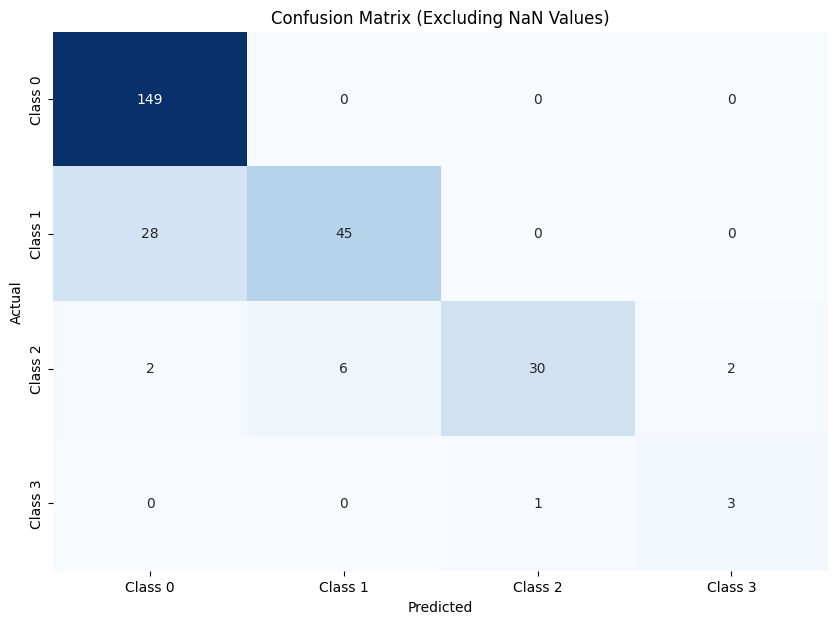

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Print predicted class labels
print("Predicted class labels:", class_labels)

# Now, to print predicted vs actual class labels
# Ensure y_test is also in the same format as class_labels
if len(y_test) == len(class_labels):
    results_df = pd.DataFrame({
        'Actual': y_test.values,        # Convert to numpy array for compatibility
        'Predicted': class_labels
    })
    print(results_df)
else:
    print("Mismatch in length between actual and predicted labels.")
    
# Exclude NaN values from y_test and class_labels
valid_indices = ~np.isnan(y_test) & ~np.isnan(class_labels)
y_test_clean = y_test[valid_indices]
class_labels_clean = class_labels[valid_indices]

# Check if the lengths match
if len(y_test_clean) == len(class_labels_clean):
    # Calculate the F1 score
    f1 = f1_score(y_test_clean, class_labels_clean, average='weighted')  # Use 'weighted' to handle class imbalance
    print(f"F1 Score (Weighted): {f1:.4f}")
    
    # Calculate the confusion matrix with non-NaN values
    cm = confusion_matrix(y_test_clean, class_labels_clean)

    # Create a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, 
                         index=[f'Class {i}' for i in range(cm.shape[0])], 
                         columns=[f'Class {i}' for i in range(cm.shape[1])])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix (Excluding NaN Values)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
else:
    print("Mismatch in length between actual and predicted labels after filtering NaNs.")
